## Exploring NCBI Gene Expression Omnibus (GEO) Metadata  
Author: Hansen Han

### Part 1: Loading & Preparing Data  
Previously downloaded GEO study data from NCBI and loaded it into a SQLite database. 

In [1]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('geo_annotations.db')

# Query the data from the geo_studies table
query = "SELECT * FROM geo_studies"

# Load data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection to the database
conn.close()

# previously did some work with annotating studies using LLMs...
# since its not relevant, lets drop that column for this analysis
df = df.drop(columns=['ai_annotation'])

df.head()

,id,study_id,status,title,organism,experiment_type,summary,citations,bioproject,platforms,num_samples,sample_ids,sample_metadata,overall_design
0,1,GSE121212,"Public on Jan 18, 2019","Atopic Dermatitis, Psoriasis and healthy contr...",Homo sapiens,Expression profiling by high throughput sequen...,To gain a deeper understanding of the pathophy...,"30641038,35862195,31891686",PRJNA496323,['GPL16791'],147,"['GSM3427868', 'GSM3427869', 'GSM3427870', 'GS...","{""patient's condition"": ['CTRL', 'PSO', 'AD'],...",We performed high-depth sequencing of 147 skin...
1,5,GSE120899,"Public on Oct 06, 2018",A Phase 2 Randomized Trial of Apremilast in Pa...,Homo sapiens,Expression profiling by array,"A phase 2, double-blind, placebo-controlled tr...",30528828,PRJNA494869,['GPL570'],58,"['GSM3418016', 'GSM3418017', 'GSM3418018', 'GS...","{'batch_date': ['2016-01-25', '2016-01-20', '2...","Patients were randomized to placebo, apremilas..."
2,11,GSE2298,"Public on Jul 20, 2005",hGSTA4-4 transfection in HLE B-3 experiment,Homo sapiens,Expression profiling by array,HLE B-3 cells were transfected with either emp...,16005854,PRJNA91677,['GPL570'],2,"['GSM42833', 'GSM42834']",{'source_name': ['pTarget transfected HLE B-3 ...,We performed high-depth sequencing of 147 skin...
3,12,GSE2327,"Public on Nov 30, 2005",siRNA mediated WTAP knockdown in HUVEC,Homo sapiens,Expression profiling by array,The experiment studied the effect of knockdown...,17088532,PRJNA91659,['GPL570'],4,"['GSM43070', 'GSM43071', 'GSM43072', 'GSM43073']",{'source_name': ['Human umbilical vein endothe...,None
4,13,GSE2397,"Public on Dec 01, 2005",LJMJDW: Cellular responses to 4-hydroxy-2-nonenal,Homo sapiens,Expression profiling by array,Cellular responses to 4-hydroxy-2-nonenal (HNE...,16300372,PRJNA91599,['GPL570'],24,"['GSM43955', 'GSM43956', 'GSM43957', 'GSM43958...",{'source_name': ['RKO human colorectal carcino...,None


I'm interested in looking at trends over time so I want to format status to get the date, lets start by removing all the rows that don't have a date string. 

In [2]:
original_len = len(df)
df = df.dropna(subset=['status'])
print(original_len - len(df), "rows removed")

36397 rows removed


After removing those, I want to see if there are any rows where "Public on" is not in the string, since I'm going to make datetime objects and want to make sure the format is consistent across rows....

In [3]:
filtered_df = df[~df['status'].str.contains("Public on")]
filtered_df

,id,study_id,status,title,organism,experiment_type,summary,citations,bioproject,platforms,num_samples,sample_ids,sample_metadata,overall_design
46703,46712,GSE425,,Acute myeloid leukemia study,Homo sapiens,Expression profiling by array,Acute myeloid leukemia study.Supplementary Tab...,"15084693,16931630,19903898",PRJNA84991,"['GPL317', 'GPL318', 'GPL319']",119,"['GSM6228', 'GSM6229', 'GSM6230', 'GSM6231', '...","{'source_name': ['CRH'], 'all_metadata_fields'...",None


Okay, there just one weird row with a blank string, lets drop it and proceed with converting the date strings into datetime objects....

In [4]:
df = df[df['status'].str.contains("Public on")]

# then lets remove Public on from each row
df['status'] = [x.replace("Public on ", "") for x in df['status']]

# now convert into a datetime object...
df['date'] = pd.to_datetime(df['status'])
df = df.drop(columns=['status'])

df.head()

# looks good....

,id,study_id,title,organism,experiment_type,summary,citations,bioproject,platforms,num_samples,sample_ids,sample_metadata,overall_design,date
0,1,GSE121212,"Atopic Dermatitis, Psoriasis and healthy contr...",Homo sapiens,Expression profiling by high throughput sequen...,To gain a deeper understanding of the pathophy...,"30641038,35862195,31891686",PRJNA496323,['GPL16791'],147,"['GSM3427868', 'GSM3427869', 'GSM3427870', 'GS...","{""patient's condition"": ['CTRL', 'PSO', 'AD'],...",We performed high-depth sequencing of 147 skin...,2019-01-18
1,5,GSE120899,A Phase 2 Randomized Trial of Apremilast in Pa...,Homo sapiens,Expression profiling by array,"A phase 2, double-blind, placebo-controlled tr...",30528828,PRJNA494869,['GPL570'],58,"['GSM3418016', 'GSM3418017', 'GSM3418018', 'GS...","{'batch_date': ['2016-01-25', '2016-01-20', '2...","Patients were randomized to placebo, apremilas...",2018-10-06
2,11,GSE2298,hGSTA4-4 transfection in HLE B-3 experiment,Homo sapiens,Expression profiling by array,HLE B-3 cells were transfected with either emp...,16005854,PRJNA91677,['GPL570'],2,"['GSM42833', 'GSM42834']",{'source_name': ['pTarget transfected HLE B-3 ...,We performed high-depth sequencing of 147 skin...,2005-07-20
3,12,GSE2327,siRNA mediated WTAP knockdown in HUVEC,Homo sapiens,Expression profiling by array,The experiment studied the effect of knockdown...,17088532,PRJNA91659,['GPL570'],4,"['GSM43070', 'GSM43071', 'GSM43072', 'GSM43073']",{'source_name': ['Human umbilical vein endothe...,None,2005-11-30
4,13,GSE2397,LJMJDW: Cellular responses to 4-hydroxy-2-nonenal,Homo sapiens,Expression profiling by array,Cellular responses to 4-hydroxy-2-nonenal (HNE...,16300372,PRJNA91599,['GPL570'],24,"['GSM43955', 'GSM43956', 'GSM43957', 'GSM43958...",{'source_name': ['RKO human colorectal carcino...,None,2005-12-01


### Experiment Types Over Time

I'm interested in looking at experiment type over time, but the data is very muddled with types fused together.

In [5]:
unique_values_counts = df['experiment_type'].value_counts()
unique_values_counts

experiment_type
Expression profiling by high throughput sequencing                                                                                                                                                                                                     78046
Expression profiling by array                                                                                                                                                                                                                          63501
Genome binding/occupancy profiling by high throughput sequencing                                                                                                                                                                                       27915
Other                                                                                                                                                                                                                            

We have to extract out all the unique componenets:

In [6]:
from tqdm import tqdm
parsed_experiment_types = []
new_strings = []
experiment_type_strings = list(unique_values_counts.keys())

for i in tqdm(experiment_type_strings):
    if i in new_strings:
        pass
    else:
        for j in experiment_type_strings:
            # if the string is an exact match, ignore it
            if i == j:
                pass
            # if this string contains a substring, remove it from new_strings
            elif j in i:
                i = i.replace(j, "")
            
            if i not in new_strings:
                pass_filtering = True
                for new_string in new_strings:
                    if new_string == i or new_string in i:
                        pass_filtering = False
                if pass_filtering:
                    new_strings.append(i)

experiment_type_options = new_strings
experiment_type_options

100%|██████████| 869/869 [00:00<00:00, 8740.61it/s]


['Expression profiling by high throughput sequencing',
 'Expression profiling by array',
 'Genome binding/occupancy profiling by high throughput sequencing',
 'Other',
 'Non-coding RNA profiling by high throughput sequencing',
 'Non-coding RNA profiling by array',
 'Methylation profiling by high throughput sequencing',
 'Genome binding/occupancy profiling by genome tiling array',
 'Methylation profiling by genome tiling array',
 'Methylation profiling by array',
 'Genome variation profiling by genome tiling array',
 'Expression profiling by RT-PCR',
 'Genome variation profiling by array',
 'Genome variation profiling by SNP array',
 'Expression profiling by genome tiling array',
 'Protein profiling by protein array',
 'SNP genotyping by SNP array',
 'Expression profiling by SAGE',
 'Third-party reanalysis',
 'Genome variation profiling by high throughput sequencing',
 'Genome binding/occupancy profiling by array',
 'Non-coding RNA profiling by genome tiling array',
 'Expression profili

100%|██████████| 24/24 [00:00<00:00, 47.93it/s] 


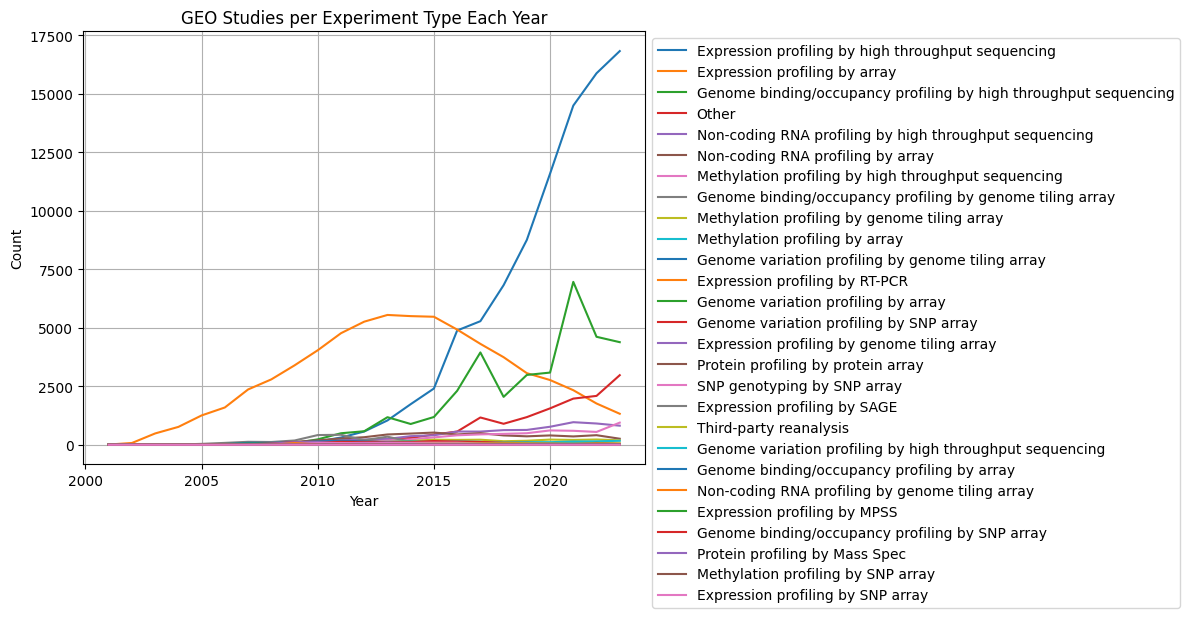

In [7]:
import matplotlib.pyplot as plt
import matplotlib

# create a new dataframe
list_of_dicts = []

df['year'] = df['date'].dt.year

year_values = list(set(df['date'].dt.year))
for year in tqdm(year_values):
    # ignore 2024 since we are only part way through the year...
    if year == 2024:
        pass
    else:
        sub_dict = {"year": year}
        df_subset = df[df.year == year]
        for experiment_type in experiment_type_options:
            count = 0
            for experiment_type_str in df_subset['experiment_type']:
                if experiment_type in experiment_type_str:
                    count = count + 1

            sub_dict[experiment_type] = count
        
        list_of_dicts.append(sub_dict)

experiment_type_count_df = pd.DataFrame(list_of_dicts)

# Set 'year' column as index
experiment_type_count_df.set_index('year', inplace=True)

# plot the figure

# Adjust figsize for a wider plot
plt.figure(figsize=(12, 6))

# Plot each column separately
for column in experiment_type_count_df.columns:
    plt.plot(experiment_type_count_df.index, experiment_type_count_df[column], label=column)
    #plt.text(experiment_type_count_df.index[-1], experiment_type_count_df[column].iloc[-1], column)


# Move the legend to the right side
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('GEO Studies per Experiment Type Each Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

### Species Over Time

In [8]:
### repeat the similar flow with species
from ast import literal_eval

count = 0
processed_organisms = []
for value in tqdm(list(df['organism'])):
    if value == None or len(value) == 0:
        processed_organisms.append(None)
    else:
        try:
            # if it is a list, ignore it
            literal_eval(df['organism'])
            count = count + 1
            processed_organisms.append(None)
        except:
            processed_organisms.append(value)


print(count, "studies ignored.")

100%|██████████| 222547/222547 [00:30<00:00, 7402.31it/s]

0 studies ignored.


100%|██████████| 24/24 [00:30<00:00,  1.27s/it]


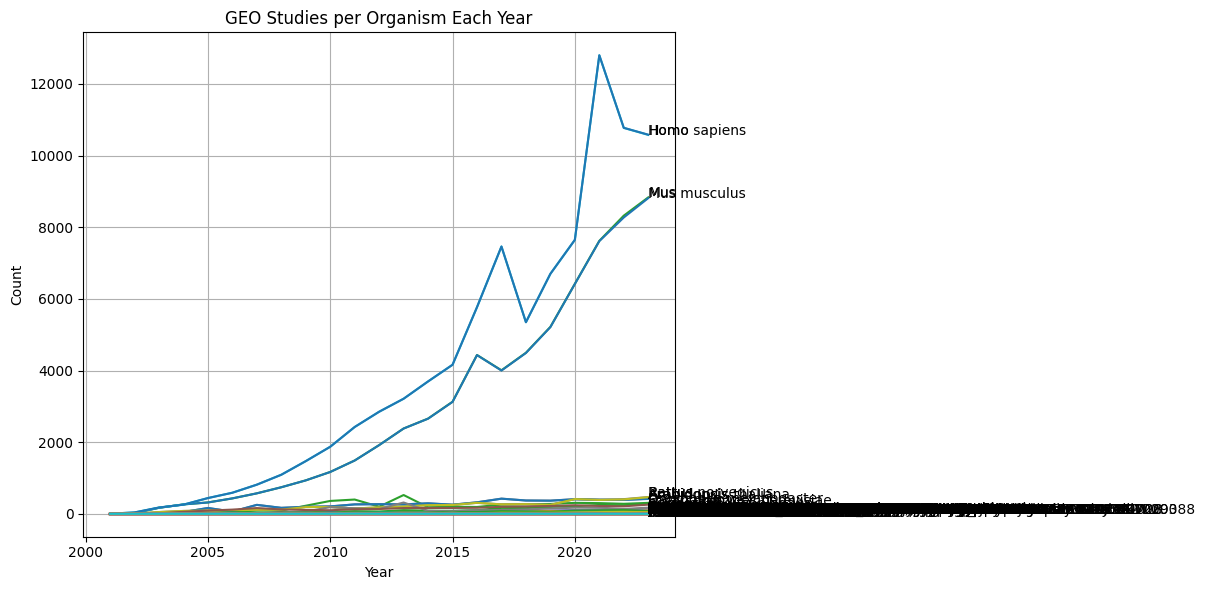

In [9]:
df['organism'] = processed_organisms
# remove NA rows
df = df.dropna(subset=['organism'])

unique_values_counts = df['organism'].value_counts()

new_strings = []

organism_options = list(set(df['organism']))

# create a new dataframe
list_of_dicts = []

df['year'] = df['date'].dt.year

year_values = list(set(df['date'].dt.year))
for year in tqdm(year_values):
    # ignore 2024 since we are only part way through the year...
    if year == 2024:
        pass
    else:
        sub_dict = {"year": year}
        df_subset = df[df.year == year]
        for organism in organism_options:
            count = 0
            for organism_str in df_subset['organism']:
                if organism in organism_str:
                    count = count + 1

            sub_dict[organism] = count
        
        list_of_dicts.append(sub_dict)

organism_count_df = pd.DataFrame(list_of_dicts)

# Set 'year' column as index
organism_count_df.set_index('year', inplace=True)

# plot the figure

# Adjust figsize for a wider plot
plt.figure(figsize=(12, 6))

# Plot each column separately
for column in organism_count_df.columns:
    try:
        plt.plot(organism_count_df.index, organism_count_df[column], label=column)
        plt.text(organism_count_df.index[-1], organism_count_df[column].iloc[-1], column)
    except:
        pass


# Move the legend to the right side
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('GEO Studies per Organism Each Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# human and mouse studies dominate 